# NHIRS usage statistics

This notebook provides a first-pass analysis of NHIRS geoserver request logs, to enable NHI to analyse who is using the service, how they are connecting, and trends in use. 

The log file is comprised of a timestamp and a JSON message that contains information on the request, which needs to be parsed to separate out the useful information.

### Notes:

* Presently there's only one dump of the log files from early September 2024. There's a [JIRA ticket with the Flying Hellfish](https://gajira.atlassian.net/browse/NHIRS-218) to create a process to save the logs on a regular basis.


### Requirements

* pandas
* geopandas
* cartopy
* seaborn


### Last updated:

Craig Arthur
September 2024

In [1]:
import pandas as pd
import geopandas as gpd
import json
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from urllib.request import urlopen
import urllib.parse

from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

PROJECTION = ccrs.PlateCarree(central_longitude=180)
TRANSFORM = ccrs.PlateCarree()

#states = cfeature.NaturalEarthFeature(
#    category='cultural',
#    name='admin_1_states_provinces_lines',
#    scale='10m',
#    facecolor='none')
#LAND = cfeature.LAND()

In [2]:
filename = r"C:\Users\u12161\Downloads\NHIRS geoserver request logs.csv"


We restrict to a subset of the URIs, so we focus on those that are requesting the geoserver endpoints. 

In [3]:

uris = ['/geoserver/nhirs/ows', '/geoserver/nhirs/wfs', '/geoserver/nhirs/wms',
        '/geoserver/access/ows', '/geoserver/access/wfs', '/geoserver/access/wms']

Define a collection of functions to manipulate the messages. Some of these extract information from the JSON message, others clean strings to remove HTML ascii codes that appear in some parts of the messages. 

In [4]:
def clean_string(string):
    cleaned = string.replace('%27', '')
    cleaned = re.sub(r"^'|'$", '', cleaned)
    return cleaned


In [5]:
def parse_message(message):
    # Initialize an empty dictionary
    parsed_dict = {}
    
    # Split the message by '&' to get key-value pairs
    pairs = message.split('&')
    
    # Loop through each pair and split by '=' to get key and value
    for pair in pairs:
        if '=' in pair:
            key, value = pair.split('=', 1)  # Split by the first '='
            # Decode the value in case it's URL encoded
            decoded_value = urllib.parse.unquote(value)
            parsed_dict[key] = decoded_value
        else:
            parsed_dict[pair] = None  # Handle cases where there's no '=' (if needed)
    
    return parsed_dict

def extractLayer(msg):
    try:
        return parse_message(msg)["LAYERS"]
    except KeyError:
        return None

def extractService(msg):
    try:
        return parse_message(msg)["SERVICE"]
    except KeyError:
        return None

def extractEvent(msg):
    try:
        cqlquery = parse_message(msg)["CQL_FILTER"]
    except:
        return None
    else:
        try:
            eventid = parse_message(cqlquery)['event_id']
            return clean_string(eventid)
        except:
            return None

In [6]:
df = pd.read_csv(filename)
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df['event_id'] = df['query_string'].apply(extractEvent)
df['layer'] = df['query_string'].apply(extractLayer)
df['hour'] = df['datetime'].dt.floor("h")
df['day'] = df['datetime'].dt.floor('d')
# Select the web service URIs:
df = df.loc[df['uri'].isin(uris)]

# Filter out my own IP (in fact this should be all GA addresses):
df = df.loc[~df['request_ip'].str.startswith('124.47')]

In [7]:
df.head()

,date,time,location,request_ip,host,uri,user_agent,query_string,bytes,datetime,event_id,layer,hour,day
0,2024-09-26,16:40:06,DUB56-P2,46.137.1.248,d26bydvks8rxpz.cloudfront.net,/geoserver/access/ows,Spatineo%20Monitor%20GetMapBot%20(http://www.s...,SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&LAYER...,3105,2024-09-26 16:40:06,None,access_exposure_report,2024-09-26 16:00:00,2024-09-26
1,2024-09-26,16:41:51,DUB56-P2,3.251.239.229,d26bydvks8rxpz.cloudfront.net,/geoserver/access/wfs,Spatineo%20Monitor%20GetMapBot%20(http://www.s...,SERVICE=WFS&REQUEST=GetFeature&VERSION=2.0.0&C...,218593,2024-09-26 16:41:51,None,None,2024-09-26 16:00:00,2024-09-26
2,2024-09-26,13:35:06,DUB56-P2,46.137.1.248,d26bydvks8rxpz.cloudfront.net,/geoserver/access/ows,Spatineo%20Monitor%20GetMapBot%20(http://www.s...,SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&LAYER...,3112,2024-09-26 13:35:06,None,access_exposure_report,2024-09-26 13:00:00,2024-09-26
3,2024-09-26,13:36:55,DUB56-P2,3.251.239.229,d26bydvks8rxpz.cloudfront.net,/geoserver/access/wfs,Spatineo%20Monitor%20GetMapBot%20(http://www.s...,SERVICE=WFS&REQUEST=GetFeature&VERSION=2.0.0&C...,178500,2024-09-26 13:36:55,None,None,2024-09-26 13:00:00,2024-09-26
4,2024-09-26,19:00:06,DUB56-P2,46.137.1.248,d26bydvks8rxpz.cloudfront.net,/geoserver/access/ows,Spatineo%20Monitor%20GetMapBot%20(http://www.s...,SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&LAYER...,3026,2024-09-26 19:00:06,None,access_exposure_report,2024-09-26 19:00:00,2024-09-26


Number of hits from each unique IP address

In [8]:
df['request_ip'].value_counts()

request_ip
46.137.1.248       5713
3.251.239.229      5713
203.22.200.36      2905
163.116.203.89     1702
163.116.203.79     1668
                   ... 
45.141.142.115        1
45.141.142.130        1
45.141.142.179        1
45.141.142.53         1
163.116.198.115       1
Name: count, Length: 243, dtype: int64

Number of requests from different applications. 

In [9]:
df['user_agent'].value_counts()

user_agent
Mozilla/5.0%20(Windows%20NT%2010.0;%20Win64;%20x64)%20AppleWebKit/537.36%20(KHTML,%20like%20Gecko)%20Chrome/128.0.0.0%20Safari/537.36%20Edg/128.0.0.0                                                                                      8938
Spatineo%20Monitor%20GetMapBot%20(http://www.spatineo.com/spatineo-monitor;%20MonitoredService%20http://directory.spatineo.com/service/155613)                                                                                             5713
Spatineo%20Monitor%20GetMapBot%20(http://www.spatineo.com/spatineo-monitor;%20MonitoredService%20http://directory.spatineo.com/service/155614)                                                                                             5713
Mozilla/5.0%20(Windows%20NT%2010.0;%20Win64;%20x64)%20AppleWebKit/537.36%20(KHTML,%20like%20Gecko)%20Chrome/128.0.0.0%20Safari/537.36                                                                                                      3108
FME/2023.7.46.23319%20%20libc

Plot a chart of the hourly rate of requests across all endpoints

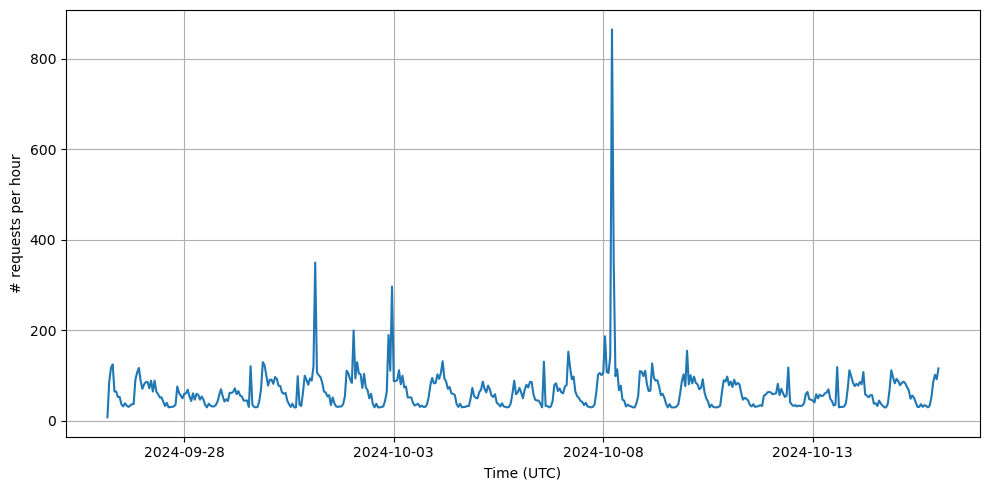

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(df.set_index('datetime').resample('h').size(), ax=ax, ) #marker='o', markersize=5)
ax.set_ylabel("# requests per hour")
ax.set_xlabel("Time (UTC)")
dateloc = mdates.DayLocator(interval=5)
datefmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(dateloc)
ax.grid()
fig.tight_layout()

Plot a stacked bar chart of the daily requests, with separate categories for each URI

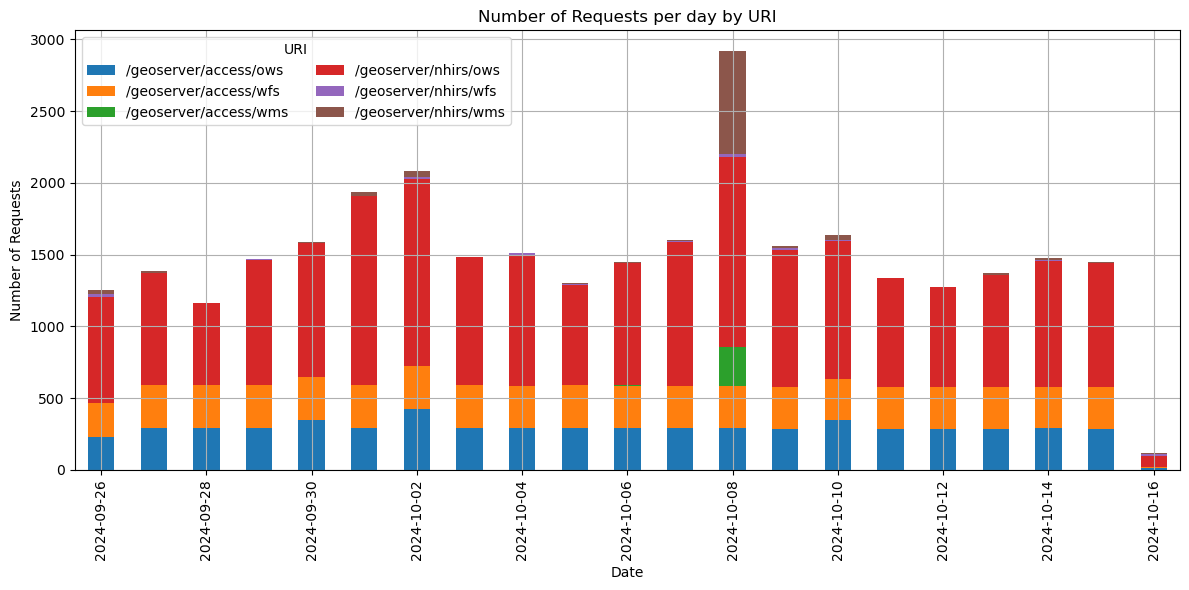

In [11]:
dfgroup = df.groupby(['day', 'uri']).size().reset_index(name='request_count')
df_pivot = dfgroup.pivot(index='day', columns='uri', values='request_count').fillna(0)
df_pivot.index = df_pivot.index.date

fig, ax = plt.subplots(1, 1,figsize=(12, 6))
ax = df_pivot.plot(kind='bar', stacked=True, ax=ax, rot=90)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Requests')
ax.set_title('Number of Requests per day by URI')
dateloc = mdates.DayLocator(interval=2)
datefmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(dateloc)
plt.legend(title='URI', ncols=2)
ax.grid()
plt.tight_layout()
plt.show()

In [13]:
df.groupby(['user_agent', 'request_ip']).size().reset_index(name='application count').to_csv(r"X:\georisk\HaRIA_B_Wind\projects\NHIRS\2. DATA\1. Work Unit Assessment\Usage\20241016_Agent_IP.csv", index=False)

Plot a chart of the daily number of unique IP adresses requesting services

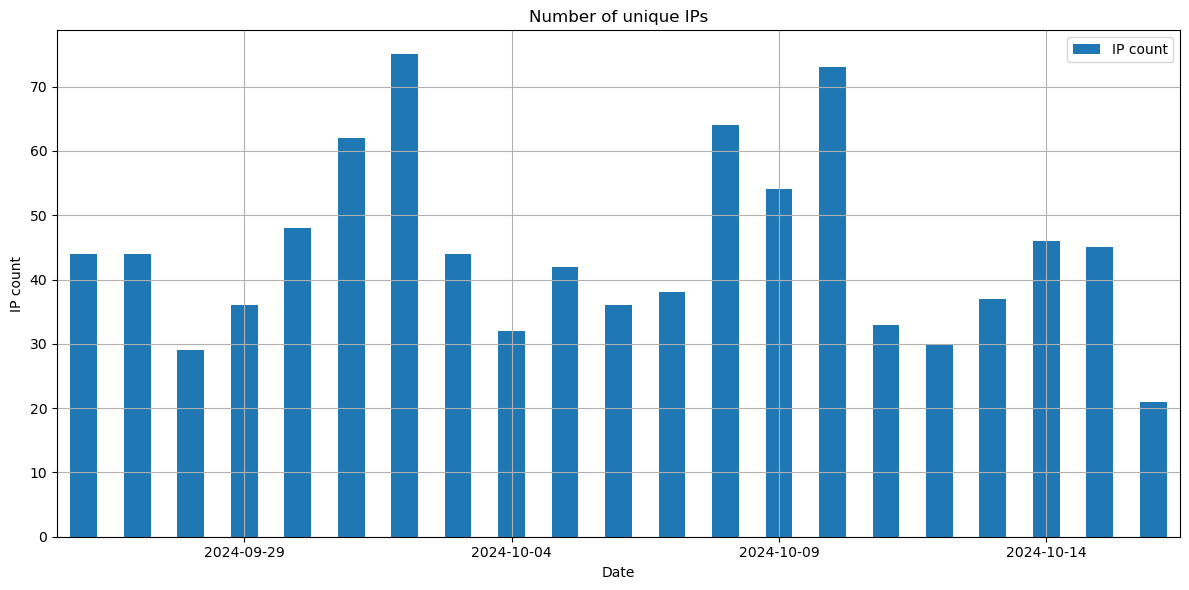

In [14]:
# Plot number of unique IP addresses by day:
dfgroup = df.groupby(['day'])['request_ip'].nunique().reset_index(name='IP count').set_index('day')
dfgroup.index = dfgroup.index.date

fig, ax = plt.subplots(1, 1,figsize=(12, 6))
ax = dfgroup.plot(kind='bar', stacked=False, ax=ax, rot=0)
ax.set_xlabel('Date')
ax.set_ylabel('IP count')
ax.set_title('Number of unique IPs')
dateloc = mdates.DayLocator(interval=5)
datefmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(dateloc)
ax.grid()
plt.tight_layout()
plt.show()

In [15]:
def extractLocation(ip):
    try:
        res = urlopen('https://ipinfo.io/' + ip + '/json')
        data = json.load(res)
        city = data['city']
        lon = float(data['loc'].split(',')[0])
        lat = float(data['loc'].split(',')[1])
        return (city, lon, lat)
    except json.JSONDecodeError:
        return None

Next we discover the location of the list of IP addresses so we can plot a map of where the services are being used. 

_Take care with this, as it may raise an access denied error if you provide too long a list_. This makes a request to an IP information page, and if we poll too many times in too short a period, the requests will be blocked. 

In [16]:
tmpdf = df['request_ip'].value_counts().reset_index()['request_ip'].apply(extractLocation, )
locdf = pd.DataFrame(tmpdf.tolist(), index=tmpdf.index, columns=['city', 'latitude', 'longitude'])
locdf['request_ip'] = df['request_ip'].value_counts().index
locgdf = gpd.GeoDataFrame(data=locdf, geometry=gpd.points_from_xy(locdf['longitude'], locdf['latitude']), crs=TRANSFORM)

Plot a map of the IP locations:

c:\W10DEV\Anaconda3\envs\process\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


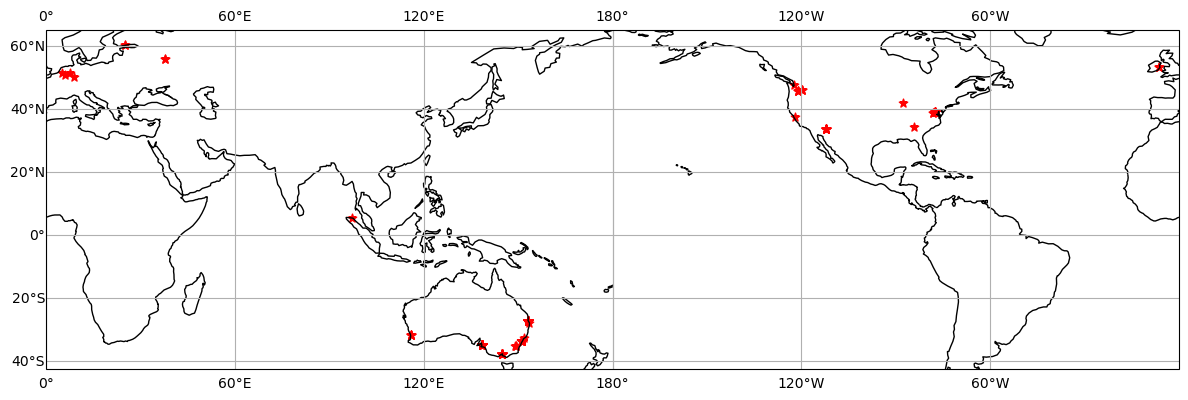

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8),
                       subplot_kw={'projection': PROJECTION})

locgdf.plot(marker="*", color='red', markersize=40, ax=ax, transform=TRANSFORM)
ax.coastlines()
#ax.add_feature(states, edgecolor='0.15', linestyle='--')
#ax.add_feature(cfeature.LAND, edgecolor='k')
gl = ax.gridlines(draw_labels=True)
#ax.set_extent((110, 160, -45, -10), crs=TRANSFORM) # Change this if you want to plot global map
fig.tight_layout()


Pivot table of the applications ('agent') that are used by each unique IP. Typically, there's only one application, but some IP addresses report more than one application, suggesting multiple users are making requests.

In [18]:
df.pivot_table(index='request_ip', columns='user_agent', values='day', aggfunc='count').fillna(0)

user_agent,-,Amazon%20CloudFront,ArcGIS%20Pro%203.0.0%20(00000000000)%20-%20ArcGISPro,ArcGIS%20Pro%203.1.0%20(00000000000)%20-%20ArcGISPro,ArcGIS%20Pro%203.1.3%20(00000000000)%20-%20ArcGISPro,ArcGIS%20Pro%203.2.2%20(00000000000)%20-%20ArcGISPro,ArcGIS%20Pro%203.3.0%20(00000000000)%20-%20ArcGISPro,ArcGIS%20Server,ArcGISRuntime-Android/100.15.6%20(Android%2014.0;%20arm64-v8a;%20SAMSUNG-SM-S918B)%20%20arcgis-fieldmaps/24.2.2%20(f1372fae-dc32-4097-b8fc-e3137b3a108b),ArcGISRuntime-Android/100.15.6%20(Android%2014.0;%20arm64-v8a;%20SAMSUNG-SM-S928B)%20%20arcgis-fieldmaps/24.2.2%20(00cb9186-717d-4261-9190-884d65f96be6),...,Mozilla/5.0%20QGIS/33003/macOS%2015.0,Mozilla/5.0%20QGIS/33407/Windows%2011%20Version%202009,Spatineo%20Monitor%20Controller%20(http://www.spatineo.com/spatineo-monitor/),Spatineo%20Monitor%20GetMapBot%20(http://www.spatineo.com/spatineo-monitor;%20MonitoredService%20http://directory.spatineo.com/service/155613),Spatineo%20Monitor%20GetMapBot%20(http://www.spatineo.com/spatineo-monitor;%20MonitoredService%20http://directory.spatineo.com/service/155614),axios/0.19.2,facebookexternalhit/1.1%20(+http://www.facebook.com/externalhit_uatext.php),magda-minion-broken-link/3.0.0,meta-externalagent/1.1%20(+https://developers.facebook.com/docs/sharing/webmasters/crawler),yacybot%20(/global;%20amd64%20Linux%206.11.2-cb1.0.fc40.x86_64;%20java%2021.0.4;%20Europe/de)%20http://yacy.net/bot.html
request_ip,,,,,,,,,,,,,,,,,,,,,
1.120.120.222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.128.17.108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.128.17.170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.132.105.103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.132.18.197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65.21.113.199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66.249.79.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66.249.79.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
